In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.18),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [3]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 238563, Validation Loss: 236194, 10798.70111039525
Epoch 101, Training Loss: 69653, Validation Loss: 63633, 197560.07368488796
Epoch 201, Training Loss: 68983, Validation Loss: 61380, 230791.000837439
Epoch 301, Training Loss: 61254, Validation Loss: 63030, 167431.80344639896
Epoch 401, Training Loss: 64386, Validation Loss: 74858, 429479.81182723143
Epoch 501, Training Loss: 60586, Validation Loss: 56993, 256397.04659626642
Epoch 601, Training Loss: 59629, Validation Loss: 60467, 177360.06948324808
Epoch 701, Training Loss: 65753, Validation Loss: 83845, 450211.0507746108
Epoch 801, Training Loss: 57319, Validation Loss: 54115, 262667.91565399326
Epoch 901, Training Loss: 57339, Validation Loss: 63300, 276699.22940436756
Epoch 1001, Training Loss: 59990, Validation Loss: 58691, 417080.5974599185
Epoch 1101, Training Loss: 55093, Validation Loss: 58419, 159074.53022960926
Epoch 1201, Training Loss: 56359, Validation Loss: 63986, 232622.6724903876
Epoch 1301, Tra

Epoch 10801, Training Loss: 55977, Validation Loss: 67091, 545644.4335251119
Epoch 10901, Training Loss: 53070, Validation Loss: 75635, 391825.4771722706
Epoch 11001, Training Loss: 50468, Validation Loss: 78568, 328380.1868201297
Epoch 11101, Training Loss: 55767, Validation Loss: 67727, 212489.31914042833
Epoch 11201, Training Loss: 56044, Validation Loss: 63164, 281466.61590254604
Epoch 11301, Training Loss: 55839, Validation Loss: 76650, 570620.8662997888
Epoch 11401, Training Loss: 55357, Validation Loss: 76760, 354088.30167406175
Epoch 11501, Training Loss: 56586, Validation Loss: 66833, 483883.4402954292
Epoch 11601, Training Loss: 55962, Validation Loss: 74655, 388820.64835901064
Epoch 11701, Training Loss: 54260, Validation Loss: 79577, 378527.5461072466
Epoch 11801, Training Loss: 56491, Validation Loss: 64375, 491001.56081084424
Epoch 11901, Training Loss: 55059, Validation Loss: 64324, 662801.3963795904
Epoch 12001, Training Loss: 55449, Validation Loss: 73933, 354484.91670

Epoch 21401, Training Loss: 62952, Validation Loss: 69374, 115368.71466200531
Epoch 21501, Training Loss: 72452, Validation Loss: 73958, 532308.2504864834
Epoch 21601, Training Loss: 107944, Validation Loss: 84053, 1605374.0756320935
Epoch 21701, Training Loss: 63155, Validation Loss: 67352, 149804.5090670701
Epoch 21801, Training Loss: 63143, Validation Loss: 69289, 210024.13840091848
Epoch 21901, Training Loss: 61682, Validation Loss: 79231, 125686.55288063863
Epoch 22001, Training Loss: 63271, Validation Loss: 70649, 350801.17523346655
Epoch 22101, Training Loss: 68418, Validation Loss: 82818, 621502.9447876915
Epoch 22201, Training Loss: 60562, Validation Loss: 73066, 255880.84146190167
Epoch 22301, Training Loss: 62627, Validation Loss: 72087, 210266.52951987798
Epoch 22401, Training Loss: 65340, Validation Loss: 79067, 208613.29318551222
Epoch 22501, Training Loss: 72106, Validation Loss: 59591, 1042829.5983035034
Epoch 22601, Training Loss: 62550, Validation Loss: 75361, 82694.1

Epoch 32001, Training Loss: 70156, Validation Loss: 83511, 1658901.3742590535
Epoch 32101, Training Loss: 74025, Validation Loss: 74209, 1557697.749852325
Epoch 32201, Training Loss: 69408, Validation Loss: 66261, 830403.7337979126
Epoch 32301, Training Loss: 65025, Validation Loss: 65598, 1056199.557867622
Epoch 32401, Training Loss: 66867, Validation Loss: 70548, 326909.76444607985
Epoch 32501, Training Loss: 67056, Validation Loss: 75195, 868396.0219451515
Epoch 32601, Training Loss: 67114, Validation Loss: 69348, 375965.06502998085
Epoch 32701, Training Loss: 67814, Validation Loss: 77072, 435151.7806768047
Epoch 32801, Training Loss: 61430, Validation Loss: 79050, 524197.6859772697
Epoch 32901, Training Loss: 63736, Validation Loss: 66582, 760368.5050342651
Epoch 33001, Training Loss: 64256, Validation Loss: 74507, 890411.4634234267
Epoch 33101, Training Loss: 63567, Validation Loss: 79573, 870560.4943919806
Epoch 33201, Training Loss: 65708, Validation Loss: 74368, 1628825.603167

Epoch 42601, Training Loss: 95715, Validation Loss: 93824, 2281.3337173699347
Epoch 42701, Training Loss: 99657, Validation Loss: 93982, 1555.4811430458576
Epoch 42801, Training Loss: 96469, Validation Loss: 93965, 2496.400727277467
Epoch 42901, Training Loss: 97946, Validation Loss: 94048, 3143.5050368304924
Epoch 43001, Training Loss: 101641, Validation Loss: 93964, 5078.109879007279
Epoch 43101, Training Loss: 95988, Validation Loss: 94195, 3329.343134452794
Epoch 43201, Training Loss: 101275, Validation Loss: 94292, 6414.105500319412
Epoch 43301, Training Loss: 101405, Validation Loss: 93679, 5028.496457837724
Epoch 43401, Training Loss: 97944, Validation Loss: 93918, 3938.2150623313246
Epoch 43501, Training Loss: 99367, Validation Loss: 93725, 2132.1682974565024
Epoch 43601, Training Loss: 98176, Validation Loss: 93887, 2042.6575275594266
Epoch 43701, Training Loss: 98492, Validation Loss: 93788, 2519.4715977689284
Epoch 43801, Training Loss: 104283, Validation Loss: 93814, 4183.1

Epoch 53201, Training Loss: 99485, Validation Loss: 93743, 2777.955808356454
Epoch 53301, Training Loss: 99903, Validation Loss: 94581, 3283.7807590750635
Epoch 53401, Training Loss: 99347, Validation Loss: 94141, 2052.790260806481
Epoch 53501, Training Loss: 100507, Validation Loss: 94495, 2028.0589146198897
Epoch 53601, Training Loss: 93699, Validation Loss: 94042, 2072.422819313529
Epoch 53701, Training Loss: 95731, Validation Loss: 93839, 3399.216880382444
Epoch 53801, Training Loss: 97626, Validation Loss: 93887, 1595.698054599901
Epoch 53901, Training Loss: 99655, Validation Loss: 93862, 1742.9439993831677
Epoch 54001, Training Loss: 95477, Validation Loss: 94231, 2154.1169689285734
Epoch 54101, Training Loss: 98097, Validation Loss: 94088, 1704.3435946188913
Epoch 54201, Training Loss: 98057, Validation Loss: 94100, 2199.591638248483
Epoch 54301, Training Loss: 100172, Validation Loss: 93957, 2808.380731862289
Epoch 54401, Training Loss: 97784, Validation Loss: 94017, 3807.70912

Epoch 63801, Training Loss: 63460, Validation Loss: 69219, 862833.3367782716
Epoch 63901, Training Loss: 64619, Validation Loss: 73823, 569828.253913273
Epoch 64001, Training Loss: 64019, Validation Loss: 78556, 728256.2404182581
Epoch 64101, Training Loss: 66506, Validation Loss: 78907, 453924.9578636059
Epoch 64201, Training Loss: 63898, Validation Loss: 78273, 532652.0059290623
Epoch 64301, Training Loss: 66764, Validation Loss: 79315, 560894.9874076423
Epoch 64401, Training Loss: 64390, Validation Loss: 66595, 285002.14530211565
Epoch 64501, Training Loss: 67627, Validation Loss: 68603, 534141.294591573
Epoch 64601, Training Loss: 64330, Validation Loss: 79733, 518786.063680452
Epoch 64701, Training Loss: 72326, Validation Loss: 70920, 944060.7839581813
Epoch 64801, Training Loss: 64054, Validation Loss: 79789, 201360.06165168143
Epoch 64901, Training Loss: 64278, Validation Loss: 79112, 981474.6913564866
Epoch 65001, Training Loss: 71118, Validation Loss: 94989, 883386.9748211396


Epoch 74401, Training Loss: 101438, Validation Loss: 93978, 3769.5300163990564
Epoch 74501, Training Loss: 110395, Validation Loss: 93697, 376852.2189056619
Epoch 74601, Training Loss: 98967, Validation Loss: 94080, 1785.5269568637996
Epoch 74701, Training Loss: 96427, Validation Loss: 93971, 2877.4834733803473
Epoch 74801, Training Loss: 96611, Validation Loss: 94241, 4937.828982748809
Epoch 74901, Training Loss: 94953, Validation Loss: 93931, 4614.876092410771
Epoch 75001, Training Loss: 100098, Validation Loss: 93975, 4647.502996397275
Epoch 75101, Training Loss: 98417, Validation Loss: 94283, 1372.5084758916798
Epoch 75201, Training Loss: 101135, Validation Loss: 94223, 1720.0341485733995
Epoch 75301, Training Loss: 100491, Validation Loss: 93966, 1574.5844906357652
Epoch 75401, Training Loss: 100052, Validation Loss: 93918, 2437.0891999308196
Epoch 75501, Training Loss: 99128, Validation Loss: 93721, 2039.35715061664
Epoch 75601, Training Loss: 99781, Validation Loss: 93801, 2635.

Epoch 85001, Training Loss: 94913, Validation Loss: 94171, 1956.949261219066
Epoch 85101, Training Loss: 104021, Validation Loss: 94117, 1921.1275255027056
Epoch 85201, Training Loss: 99784, Validation Loss: 93936, 2101.0268793118425
Epoch 85301, Training Loss: 99604, Validation Loss: 94277, 2745.076568170279
Epoch 85401, Training Loss: 94717, Validation Loss: 94021, 1763.0138535481826
Epoch 85501, Training Loss: 96276, Validation Loss: 94207, 2143.1707911514363
Epoch 85601, Training Loss: 96789, Validation Loss: 94413, 5018.699240435227
Epoch 85701, Training Loss: 97729, Validation Loss: 93798, 2669.993021966977
Epoch 85801, Training Loss: 102586, Validation Loss: 94054, 3162.392857311656
Epoch 85901, Training Loss: 95947, Validation Loss: 93944, 3930.802550916988
Epoch 86001, Training Loss: 98245, Validation Loss: 93788, 2373.4213505587995
Epoch 86101, Training Loss: 102746, Validation Loss: 93708, 5237.231426607096
Epoch 86201, Training Loss: 96050, Validation Loss: 94545, 4534.8089

Epoch 95601, Training Loss: 62033, Validation Loss: 65842, 794938.8040044139
Epoch 95701, Training Loss: 65923, Validation Loss: 64115, 908542.9705859289
Epoch 95801, Training Loss: 66951, Validation Loss: 73582, 675977.9126378841
Epoch 95901, Training Loss: 66751, Validation Loss: 75342, 189933.14875108047
Epoch 96001, Training Loss: 65098, Validation Loss: 71693, 640816.749794595
Epoch 96101, Training Loss: 68941, Validation Loss: 76682, 489430.7460001979
Epoch 96201, Training Loss: 63206, Validation Loss: 65796, 247582.12912151788
Epoch 96301, Training Loss: 67117, Validation Loss: 72483, 1098464.285355083
Epoch 96401, Training Loss: 63564, Validation Loss: 72648, 264274.8152698384
Epoch 96501, Training Loss: 74254, Validation Loss: 76448, 1358719.4506500682
Epoch 96601, Training Loss: 68414, Validation Loss: 66098, 788401.7266213461
Epoch 96701, Training Loss: 63478, Validation Loss: 64548, 1059001.9947434803
Epoch 96801, Training Loss: 62694, Validation Loss: 66581, 534768.3887425

Epoch 106201, Training Loss: 60528, Validation Loss: 66121, 685010.3698228889
Epoch 106301, Training Loss: 63221, Validation Loss: 80865, 595542.1435458864
Epoch 106401, Training Loss: 57347, Validation Loss: 65061, 394529.6907316085
Epoch 106501, Training Loss: 61525, Validation Loss: 64086, 388239.80392319616
Epoch 106601, Training Loss: 59234, Validation Loss: 61735, 412860.51927820226
Epoch 106701, Training Loss: 57373, Validation Loss: 62296, 360213.63499049545
Epoch 106801, Training Loss: 59812, Validation Loss: 68091, 822522.5267864079
Epoch 106901, Training Loss: 67425, Validation Loss: 69392, 1401018.5028117448
Epoch 107001, Training Loss: 72114, Validation Loss: 59354, 651015.2126993528
Epoch 107101, Training Loss: 72232, Validation Loss: 61469, 876472.4935348779
Epoch 107201, Training Loss: 70741, Validation Loss: 68247, 1106425.2113617293
Epoch 107301, Training Loss: 67184, Validation Loss: 63713, 728586.5777853788
Epoch 107401, Training Loss: 71996, Validation Loss: 65023,

Epoch 116701, Training Loss: 95481, Validation Loss: 94597, 4524.398892894055
Epoch 116801, Training Loss: 99961, Validation Loss: 94136, 7298.857277780279
Epoch 116901, Training Loss: 98834, Validation Loss: 93819, 5734.083451397718
Epoch 117001, Training Loss: 102211, Validation Loss: 94329, 6951.52898006071
Epoch 117101, Training Loss: 98612, Validation Loss: 93681, 5323.618149733385
Epoch 117201, Training Loss: 95199, Validation Loss: 94478, 6117.159254192381
Epoch 117301, Training Loss: 96971, Validation Loss: 94017, 5441.092145740057
Epoch 117401, Training Loss: 101788, Validation Loss: 94066, 4276.125417085766
Epoch 117501, Training Loss: 96879, Validation Loss: 93715, 5461.079377595044
Epoch 117601, Training Loss: 98629, Validation Loss: 94968, 5790.2017684142775
Epoch 117701, Training Loss: 96740, Validation Loss: 94184, 6275.954157127421
Epoch 117801, Training Loss: 99888, Validation Loss: 93874, 4276.473391896532
Epoch 117901, Training Loss: 96800, Validation Loss: 94131, 44

Epoch 127201, Training Loss: 66665, Validation Loss: 77914, 181175.46062829762
Epoch 127301, Training Loss: 68147, Validation Loss: 79247, 240255.53609880016
Epoch 127401, Training Loss: 73086, Validation Loss: 68664, 1070686.9891323876
Epoch 127501, Training Loss: 71268, Validation Loss: 78681, 143085.4503715119
Epoch 127601, Training Loss: 67776, Validation Loss: 66660, 705066.7283168201
Epoch 127701, Training Loss: 66949, Validation Loss: 71658, 243409.7821979459
Epoch 127801, Training Loss: 63272, Validation Loss: 73169, 371141.9088555433
Epoch 127901, Training Loss: 65043, Validation Loss: 77466, 649180.8521540825
Epoch 128001, Training Loss: 66249, Validation Loss: 86504, 338419.359388611
Epoch 128101, Training Loss: 64347, Validation Loss: 66518, 754772.7388098316
Epoch 128201, Training Loss: 64293, Validation Loss: 72629, 269245.2433118842
Epoch 128301, Training Loss: 66348, Validation Loss: 71142, 446768.16276262613
Epoch 128401, Training Loss: 71162, Validation Loss: 72680, 7

Epoch 137701, Training Loss: 64882, Validation Loss: 67471, 239097.0378617594
Epoch 137801, Training Loss: 64664, Validation Loss: 68158, 279797.4219140312
Epoch 137901, Training Loss: 62471, Validation Loss: 66623, 924278.4831408149
Epoch 138001, Training Loss: 68371, Validation Loss: 67097, 752145.23111811
Epoch 138101, Training Loss: 66059, Validation Loss: 66284, 558417.1613635086
Epoch 138201, Training Loss: 68496, Validation Loss: 87258, 395938.43230651645
Epoch 138301, Training Loss: 64871, Validation Loss: 69563, 309456.2353187422
Epoch 138401, Training Loss: 66222, Validation Loss: 72328, 261600.18545081106
Epoch 138501, Training Loss: 65284, Validation Loss: 68347, 529916.5929896153
Epoch 138601, Training Loss: 61353, Validation Loss: 71652, 904476.5350853493
Epoch 138701, Training Loss: 65363, Validation Loss: 70601, 544967.9563309755
Epoch 138801, Training Loss: 87984, Validation Loss: 87115, 2637182.794781905
Epoch 138901, Training Loss: 66385, Validation Loss: 69223, 4768

Epoch 148201, Training Loss: 64846, Validation Loss: 78699, 338958.15323787386
Epoch 148301, Training Loss: 63845, Validation Loss: 75043, 882821.6321308069
Epoch 148401, Training Loss: 66786, Validation Loss: 65846, 627208.0247179816
Epoch 148501, Training Loss: 64562, Validation Loss: 69359, 847075.477560493
Epoch 148601, Training Loss: 65862, Validation Loss: 71537, 627560.2094726902
Epoch 148701, Training Loss: 67824, Validation Loss: 64015, 848228.4078145024
Epoch 148801, Training Loss: 63965, Validation Loss: 75121, 793946.9743618782
Epoch 148901, Training Loss: 65420, Validation Loss: 65280, 772048.0616776821
Epoch 149001, Training Loss: 62987, Validation Loss: 81666, 673707.0097583625
Epoch 149101, Training Loss: 67388, Validation Loss: 74448, 849526.2275105979
Epoch 149201, Training Loss: 69045, Validation Loss: 70650, 1227506.9884931755
Epoch 149301, Training Loss: 63661, Validation Loss: 72880, 660150.397700366
Epoch 149401, Training Loss: 63728, Validation Loss: 67957, 5736

Epoch 158701, Training Loss: 98533, Validation Loss: 93818, 2738.2471947718386
Epoch 158801, Training Loss: 97306, Validation Loss: 93954, 2052.750196326632
Epoch 158901, Training Loss: 99344, Validation Loss: 94200, 2679.2926392045824
Epoch 159001, Training Loss: 101948, Validation Loss: 93938, 3793.0145013127403
Epoch 159101, Training Loss: 97235, Validation Loss: 94122, 2014.891641997264
Epoch 159201, Training Loss: 93587, Validation Loss: 94040, 6419.888833320379
Epoch 159301, Training Loss: 98804, Validation Loss: 94305, 4467.454403721933
Epoch 159401, Training Loss: 97703, Validation Loss: 93968, 1943.085067702688
Epoch 159501, Training Loss: 98575, Validation Loss: 94431, 2532.7610440870394
Epoch 159601, Training Loss: 92720, Validation Loss: 94423, 4569.325697111987
Epoch 159701, Training Loss: 96711, Validation Loss: 94374, 3729.6666045940256
Epoch 159801, Training Loss: 97800, Validation Loss: 94174, 2719.7452483079073
Epoch 159901, Training Loss: 96860, Validation Loss: 9380

Epoch 169201, Training Loss: 61081, Validation Loss: 79959, 277712.8462632758
Epoch 169301, Training Loss: 67225, Validation Loss: 69256, 221548.82478340273
Epoch 169401, Training Loss: 68895, Validation Loss: 71727, 476480.6967266742
Epoch 169501, Training Loss: 63638, Validation Loss: 80925, 854892.0917004693
Epoch 169601, Training Loss: 65261, Validation Loss: 60440, 374845.2335954532
Epoch 169701, Training Loss: 67595, Validation Loss: 72458, 178188.461389218
Epoch 169801, Training Loss: 63243, Validation Loss: 71694, 444865.1505868214
Epoch 169901, Training Loss: 64296, Validation Loss: 73139, 337402.9590722719
Epoch 170001, Training Loss: 68919, Validation Loss: 70585, 390425.85808031604
Epoch 170101, Training Loss: 67463, Validation Loss: 72152, 381469.5806553036
Epoch 170201, Training Loss: 63909, Validation Loss: 73476, 210845.98533744915
Epoch 170301, Training Loss: 60345, Validation Loss: 77740, 269744.8144472368
Epoch 170401, Training Loss: 65468, Validation Loss: 79405, 11

Epoch 179701, Training Loss: 93940, Validation Loss: 94425, 3222.145064819089
Epoch 179801, Training Loss: 97106, Validation Loss: 93747, 5778.188817130965
Epoch 179901, Training Loss: 94313, Validation Loss: 93826, 1476.7637191678148
Epoch 180001, Training Loss: 101566, Validation Loss: 94109, 2719.7305687024477
Epoch 180101, Training Loss: 96598, Validation Loss: 93746, 4189.75623450388
Epoch 180201, Training Loss: 100479, Validation Loss: 94059, 2149.9870204879244
Epoch 180301, Training Loss: 98054, Validation Loss: 94472, 1832.688849050788
Epoch 180401, Training Loss: 96364, Validation Loss: 94143, 3339.8254931389943
Epoch 180501, Training Loss: 95482, Validation Loss: 94402, 3565.3212888067733
Epoch 180601, Training Loss: 102169, Validation Loss: 93798, 2209.9954431068923
Epoch 180701, Training Loss: 117968, Validation Loss: 93845, 367509.1862474818
Epoch 180801, Training Loss: 99442, Validation Loss: 93974, 3796.000395473664
Epoch 180901, Training Loss: 95784, Validation Loss: 93

Epoch 190201, Training Loss: 63716, Validation Loss: 76258, 644526.8476683454
Epoch 190301, Training Loss: 68439, Validation Loss: 69594, 489160.02800204215
Epoch 190401, Training Loss: 69706, Validation Loss: 70781, 665677.0455972129
Epoch 190501, Training Loss: 65957, Validation Loss: 72974, 468026.68521482777
Epoch 190601, Training Loss: 69766, Validation Loss: 72796, 267273.61360439606
Epoch 190701, Training Loss: 71404, Validation Loss: 76455, 517799.98764765327
Epoch 190801, Training Loss: 70606, Validation Loss: 69939, 343058.31994845165
Epoch 190901, Training Loss: 87100, Validation Loss: 60021, 2623943.3062306317
Epoch 191001, Training Loss: 64269, Validation Loss: 74084, 366583.2191454871
Epoch 191101, Training Loss: 70548, Validation Loss: 63217, 715084.5936125814
Epoch 191201, Training Loss: 72676, Validation Loss: 79894, 457970.55408549146
Epoch 191301, Training Loss: 65390, Validation Loss: 74446, 340170.66752494936
Epoch 191401, Training Loss: 70243, Validation Loss: 656

Epoch 200701, Training Loss: 97952, Validation Loss: 93744, 3805.470124708623
Epoch 200801, Training Loss: 100650, Validation Loss: 93743, 3798.4269284157394
Epoch 200901, Training Loss: 97273, Validation Loss: 93884, 2902.6751049780255
Epoch 201001, Training Loss: 97834, Validation Loss: 94203, 2203.1431854162993
Epoch 201101, Training Loss: 100913, Validation Loss: 94019, 1759.0949626171757
Epoch 201201, Training Loss: 97005, Validation Loss: 93902, 4458.710087523732
Epoch 201301, Training Loss: 97890, Validation Loss: 94181, 1635.0903164559434
Epoch 201401, Training Loss: 92114, Validation Loss: 93874, 1612.6010147722802
Epoch 201501, Training Loss: 99717, Validation Loss: 93833, 4326.9531507344755
Epoch 201601, Training Loss: 96445, Validation Loss: 93932, 1462.167377868044
Epoch 201701, Training Loss: 96848, Validation Loss: 93786, 2014.6527942209461
Epoch 201801, Training Loss: 100030, Validation Loss: 94046, 1967.6982014520172
Epoch 201901, Training Loss: 95687, Validation Loss:

KeyboardInterrupt: 

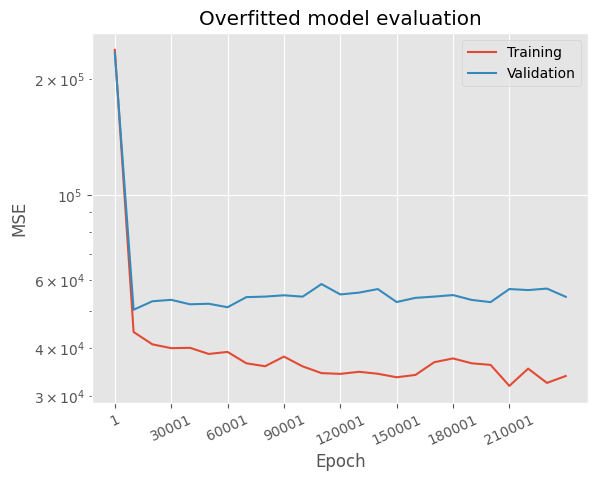

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)